# Baseline model

Split the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from xverse.feature_subset import SplitXY

def splitXY(df, target_column):

    clf = SplitXY([target_column]) #Split the dataset into X and y
    X, y = clf.fit_transform(df) #returns features (X) dataset and target(Y) as a numpy array
    return X, y

def make_train_test_split(X=None, y=None, test_size=0.3, random_state=1234):

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [4]:
selected_vars = ['V11', 'V12', 'V3', 'V19', 'V7', 'V14', 'V1', 'V4', 'V21', 'V2', 'V18', 'V16', 'V17', 'V9', 'V10']

# Build logistic regression model

In [5]:
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [6]:
def build_model(X, y):

    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

In [7]:
def evaluate_model(clf, X, y):
    
    pred = clf.predict(X) #predicted classes
    accuracy = accuracy_score(pred,y) # calculate accuracy
    fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1]) # roc_curve
    auc_value = auc(fpr,tpr) # auc_value
    report = classification_report(y, pred, labels=[0,1], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.reset_index()
    model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
    model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
    model_eval['ROC']  = auc_value
    cf_matrix = confusion_matrix(y, pred)
    
    return model_eval, cf_matrix

In [8]:
def model_eval_data(clf, X_train, y_train, 
                         X_test, y_test, 
                         model_eval_train, 
                         model_eval_test,
                         Name=None):
    
    temp_eval_train, cf_matrix_train = evaluate_model(clf, X_train, y_train)
    temp_eval_test, cf_matrix_test = evaluate_model(clf, X_test, y_test)
    temp_eval_train.index = [Name]
    temp_eval_test.index = [Name]
    
    try:
        model_eval_train = model_eval_train.append(temp_eval_train)
        model_eval_test = model_eval_test.append(temp_eval_test)
    except:
        model_eval_train = temp_eval_train
        model_eval_test = temp_eval_test
    
    return model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test

In [9]:
def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

In [10]:
model_eval_train = pd.DataFrame({},[])
model_eval_test = pd.DataFrame({},[])

Using imbalanced data

In [11]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)

In [12]:
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [13]:
clf = build_model(X_train, y_train)

In [14]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='imbalanced data - LogisticRegression')

In [15]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718


In [16]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.57037,0.681416,0.999157,0.96878


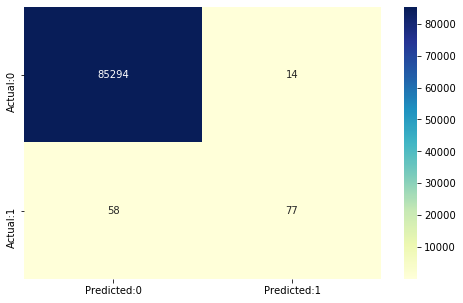

In [17]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.85      0.57      0.68       135

    accuracy                           1.00     85443
   macro avg       0.92      0.79      0.84     85443
weighted avg       1.00      1.00      1.00     85443



Change threshold

In [19]:
from sklearn.preprocessing import binarize

sensitivity_result = []
specifity_result = []
for i in range(0,11):
    cm2=0
    y_pred_prob_yes=clf.predict_proba(X_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    sensitivity_result.append(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])))
    specifity_result.append(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])))
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.0 threshold the Confusion Matrix is  
 [[    0 85308]
 [    0   135]] 
 with 135 correct predictions and 0 Type II errors( False Negatives) 

 Sensitivity:  1.0 Specificity:  0.0 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.1 threshold the Confusion Matrix is  
 [[85277    31]
 [   33   102]] 
 with 85379 correct predictions and 33 Type II errors( False Negatives) 

 Sensitivity:  0.7555555555555555 Specificity:  0.9996366108688517 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.2 threshold the Confusion Matrix is  
 [[85283    25]
 [   46    89]] 
 with 85372 correct predictions and 46 Type II errors( False Negatives) 

 Sensitivity:  0.6592592592592592 Specificity:  0.9997069442490739 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.3 threshold the Confusion Matrix is  
 [[85284    24]
 [   51    84]] 
 with 85368 correct predictions and 51 Type II errors( False Negatives) 

 Sensitivity:  0.6222222222222222 Specificity:  0.999718666479111 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.4 threshold the Confusion Matrix is  
 [[85290    18]
 [   56    79]] 
 with 85369 correct predictions and 56 Type II errors( False Negatives) 

 Sensitivity:  0.5851851851851851 Specificity:  0.9997889998593332 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.5 threshold the Confusion Matrix is  
 [[85294    14]
 [   58    77]] 
 with 85371 correct predictions and 58 Type II errors( False Negatives) 

 Sensitivity:  0.5703703703703704 Specificity:  0.9998358887794814 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.6 threshold the Confusion Matrix is  
 [[85295    13]
 [   60    75]] 
 with 85370 correct predictions and 60 Type II errors( False Negatives) 

 Sensitivity:  0.5555555555555556 Specificity:  0.9998476110095185 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.7 threshold the Confusion Matrix is  
 [[85296    12]
 [   62    73]] 
 with 85369 correct predictions and 62 Type II errors( False Negatives) 

 Sensitivity:  0.5407407407407407 Specificity:  0.9998593332395554 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.8 threshold the Confusion Matrix is  
 [[85296    12]
 [   64    71]] 
 with 85367 correct predictions and 64 Type II errors( False Negatives) 

 Sensitivity:  0.5259259259259259 Specificity:  0.9998593332395554 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.9 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.9 threshold the Confusion Matrix is  
 [[85297    11]
 [   74    61]] 
 with 85358 correct predictions and 74 Type II errors( False Negatives) 

 Sensitivity:  0.45185185185185184 Specificity:  0.9998710554695925 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=1.0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 1.0 threshold the Confusion Matrix is  
 [[85308     0]
 [  135     0]] 
 with 85308 correct predictions and 135 Type II errors( False Negatives) 

 Sensitivity:  0.0 Specificity:  1.0 





Threshold higher,sensitivity lower, specificity higher.

[0.   0.77 1.  ] [1.   0.76 0.  ]
[0.   0.78 1.  ] [1.   0.66 0.  ]
[0.   0.78 1.  ] [1.   0.62 0.  ]
[0.   0.81 1.  ] [1.   0.59 0.  ]
[0.   0.85 1.  ] [1.   0.57 0.  ]
[0.   0.85 1.  ] [1.   0.56 0.  ]
[0.   0.86 1.  ] [1.   0.54 0.  ]
[0.   0.86 1.  ] [1.   0.53 0.  ]
[0.   0.85 1.  ] [1.   0.45 0.  ]


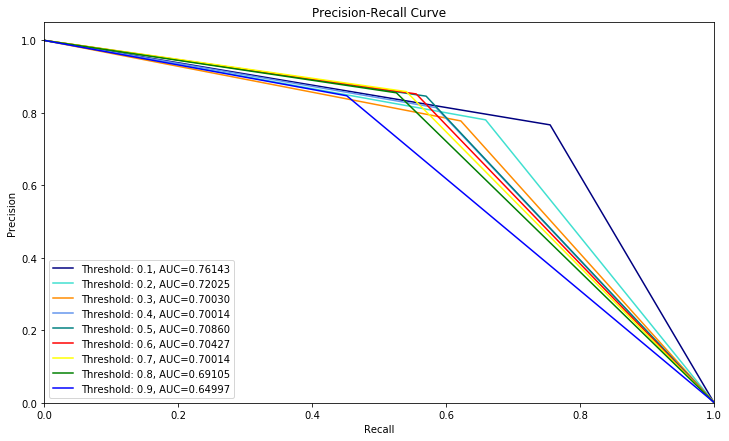

In [41]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(12,7))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_prob_yes[:,1] > i 

    precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions_prob)
    print(precision, recall)
    area = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s, AUC=%0.5f' %(i , area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

Recall metric in the testing dataset while threshold=0.1: 0.7555555555555555
Recall metric in the testing dataset while threshold=0.2: 0.6592592592592592
Recall metric in the testing dataset while threshold=0.3: 0.6222222222222222
Recall metric in the testing dataset while threshold=0.4: 0.5851851851851851
Recall metric in the testing dataset while threshold=0.5: 0.5703703703703704
Recall metric in the testing dataset while threshold=0.6: 0.5555555555555556
Recall metric in the testing dataset while threshold=0.7: 0.5407407407407407
Recall metric in the testing dataset while threshold=0.8: 0.5259259259259259
Recall metric in the testing dataset while threshold=0.9: 0.45185185185185184


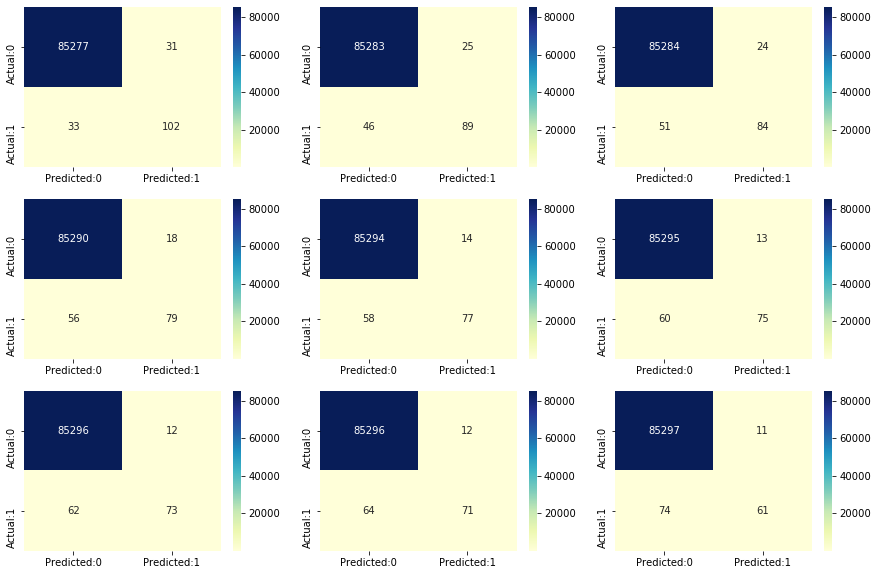

In [39]:
plt.figure(figsize=(15,10))
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
j = 1
for i in thresholds:
    y_test_predictions_prob=y_pred_prob_yes[:,1] > i
    plt.subplot(3,3,j)
    j += 1
    cnf_matrix = confusion_matrix(y_test,y_test_predictions_prob)
    np.set_printoptions(precision=2)
    print('Recall metric in the test dataset while threshold=%s:'%i,cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])) 
    conf_matrix=pd.DataFrame(data=cnf_matrix,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

# Using imbalanced data without feature selection

In [19]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)

In [20]:
clf1 = build_model(X_train, y_train)

C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf1, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='imbalanced data - LogisticRegression(without FS)')

In [22]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974


In [23]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542


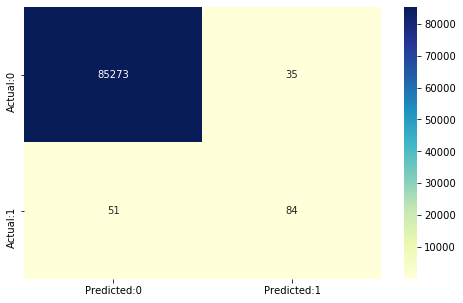

In [24]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf1.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.71      0.62      0.66       135

    accuracy                           1.00     85443
   macro avg       0.85      0.81      0.83     85443
weighted avg       1.00      1.00      1.00     85443



# Randomsampling+Logistic regression

This is the baseline model using imbalanced data and simple logistic regression.

Then I will use the first sampling techniques on it: Random oversampling

In [26]:
from imblearn.over_sampling import RandomOverSampler

In [27]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [28]:
X_resampled, y_resampled = RandomOverSampler().fit_sample(X_train, y_train)

In [29]:
clf2 = build_model(X_resampled, y_resampled)

In [30]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf2, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='RandomOversampling - Logistic Regression')

In [31]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974
RandomOversampling data,0.083702,0.901961,0.153187,0.982143,0.979792


In [32]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
RandomOversampling data,0.073354,0.866667,0.135260,0.982491,0.981285


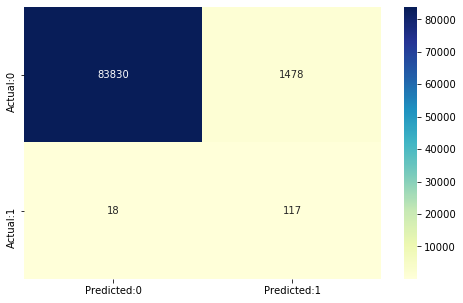

In [33]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf2.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85308
           1       0.07      0.87      0.14       135

    accuracy                           0.98     85443
   macro avg       0.54      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443



# Smote-logisticregression

In [35]:
from imblearn.over_sampling import SMOTE
#from sklearn.model_selection import GridSearchCV

In [36]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=0)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [37]:
smote = SMOTE(random_state=5)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [38]:
clf3 = build_model(X_sm, y_sm)

In [39]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf3, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='SMOTE - LogisticRegression')

In [40]:
y_pred = clf3.predict(X_test)

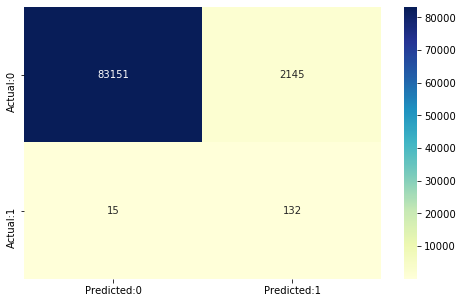

In [41]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf3.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [42]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974
RandomOversampling data,0.083702,0.901961,0.153187,0.982143,0.979792
SMOTE - LogisticRegression,0.057586,0.904348,0.108277,0.974223,0.980405


In [43]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
RandomOversampling data,0.073354,0.866667,0.135260,0.982491,0.981285
SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955


In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85296
           1       0.06      0.90      0.11       147

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.97      0.99     85443



# Borderline-Smote+Logistic Regression

In [45]:
from imblearn.over_sampling import BorderlineSMOTE

In [46]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [47]:
bsm = BorderlineSMOTE(random_state=1,kind="borderline-1")

In [48]:
X_bsm, y_bsm = bsm.fit_resample(X_train, y_train)

In [49]:
clf5 = build_model(X_bsm, y_bsm)

In [50]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf5, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='Borderline-SMOTE - LogisticRegression')

In [51]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974
RandomOversampling data,0.083702,0.901961,0.153187,0.982143,0.979792
SMOTE - LogisticRegression,0.057586,0.904348,0.108277,0.974223,0.980405
Borderline-SMOTE - LogisticRegression,0.172622,0.879552,0.288603,0.992235,0.948088


In [52]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
RandomOversampling data,0.073354,0.866667,0.135260,0.982491,0.981285
SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955
Borderline-SMOTE - LogisticRegression,0.147175,0.829630,0.250000,0.992135,0.933410


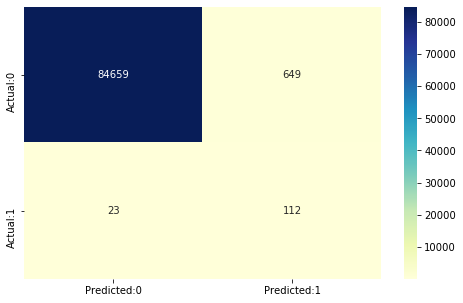

In [53]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf5.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85308
           1       0.15      0.83      0.25       135

    accuracy                           0.99     85443
   macro avg       0.57      0.91      0.62     85443
weighted avg       1.00      0.99      0.99     85443



ADASYN

In [55]:
from imblearn.over_sampling import ADASYN 

In [56]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [57]:
ada = ADASYN()
adaX, aday = ada.fit_sample(X_train, y_train)

In [58]:
clf4 = build_model(adaX, aday)

In [59]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf4, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='ADASYN LogisticRegression')

In [60]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974
RandomOversampling data,0.083702,0.901961,0.153187,0.982143,0.979792
SMOTE - LogisticRegression,0.057586,0.904348,0.108277,0.974223,0.980405
Borderline-SMOTE - LogisticRegression,0.172622,0.879552,0.288603,0.992235,0.948088
ADASYN LogisticRegression,0.016256,0.952381,0.031967,0.896712,0.980465


In [61]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
RandomOversampling data,0.073354,0.866667,0.135260,0.982491,0.981285
SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955
Borderline-SMOTE - LogisticRegression,0.147175,0.829630,0.250000,0.992135,0.933410
ADASYN LogisticRegression,0.014632,0.970370,0.028829,0.896703,0.982815


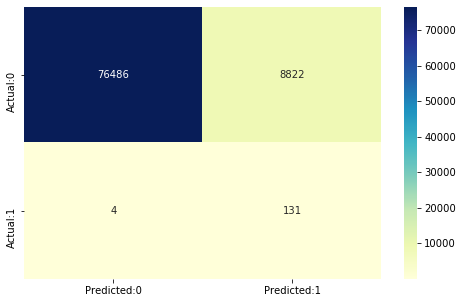

In [62]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf4.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85308
           1       0.01      0.97      0.03       135

    accuracy                           0.90     85443
   macro avg       0.51      0.93      0.49     85443
weighted avg       1.00      0.90      0.94     85443



# Comparison of different models

In [64]:
final_eval_test = model_eval_test.copy(deep=True)

In [65]:
model_eval_test.reset_index(inplace=True)

In [66]:
model_eval_test.rename({'index': 'Method'}, axis=1, inplace=True)

General Result

In [67]:
model_eval_test

,Method,precision,recall,f1-score,accuracy,ROC
0,imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
1,imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
2,RandomOversampling data,0.073354,0.866667,0.135260,0.982491,0.981285
3,SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955
4,Borderline-SMOTE - LogisticRegression,0.147175,0.829630,0.250000,0.992135,0.933410
5,ADASYN LogisticRegression,0.014632,0.970370,0.028829,0.896703,0.982815


In [68]:
tidy = model_eval_test.melt(id_vars='Method').rename(columns=str.title)

In [88]:
tidy

,Method,Variable,Value
0,imbalanced data - LogisticRegression,precision,0.846154
1,imbalanced data - LogisticRegression(without FS),precision,0.705882
2,RandomOversampling data,precision,0.073354
3,SMOTE - LogisticRegression,precision,0.057971
4,Borderline-SMOTE - LogisticRegression,precision,0.147175
5,ADASYN LogisticRegression,precision,0.014632
6,imbalanced data - LogisticRegression,recall,0.570370
7,imbalanced data - LogisticRegression(without FS),recall,0.622222
8,RandomOversampling data,recall,0.866667
9,SMOTE - LogisticRegression,recall,0.897959


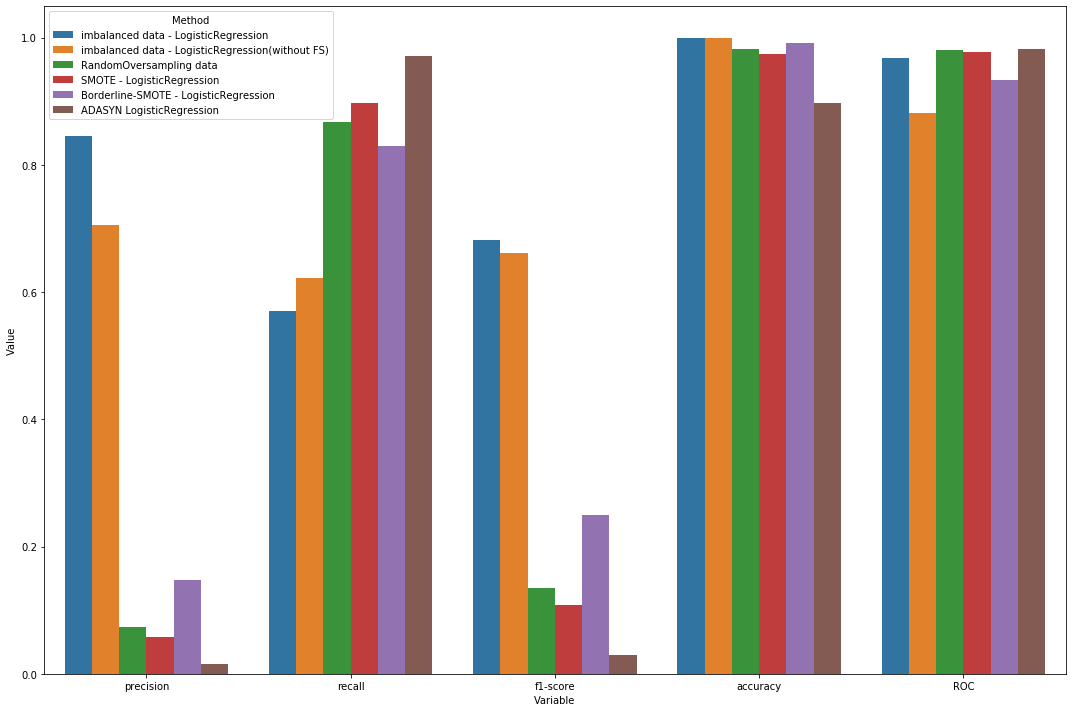

In [69]:
plt.figure(figsize=(15,10))
sns.barplot(x='Variable', y='Value', hue='Method', data=tidy)
plt.tight_layout()

Focus on Minority class

In [70]:
data = {'F1 score':[0.68,0.66,0.14,0.11,0.25,0.03],
       'Recall':[0.57,0.62,0.87,0.90,0.83,0.97],
        'Precision':[0.85,0.71,0.07,0.06,0.15,0.01],
       'Method':['imbalanced data - LogisticRegression','imbalanced data - LogisticRegression(without FS)','RandomOversampling data','SMOTE - LogisticRegression','Borderline-SMOTE - LogisticRegression','ADASYN LogisticRegression']}

In [105]:
from pandas import Series,DataFrame
import pandas as pd

df_analysis = DataFrame(data)
df_analysis

,F1 score,Recall,Precision,Method
0,0.68,0.57,0.85,imbalanced data - LogisticRegression
1,0.66,0.62,0.71,imbalanced data - LogisticRegression(without FS)
2,0.14,0.87,0.07,RandomOversampling data
3,0.11,0.90,0.06,SMOTE - LogisticRegression
4,0.25,0.83,0.15,Borderline-SMOTE - LogisticRegression
5,0.03,0.97,0.01,ADASYN LogisticRegression


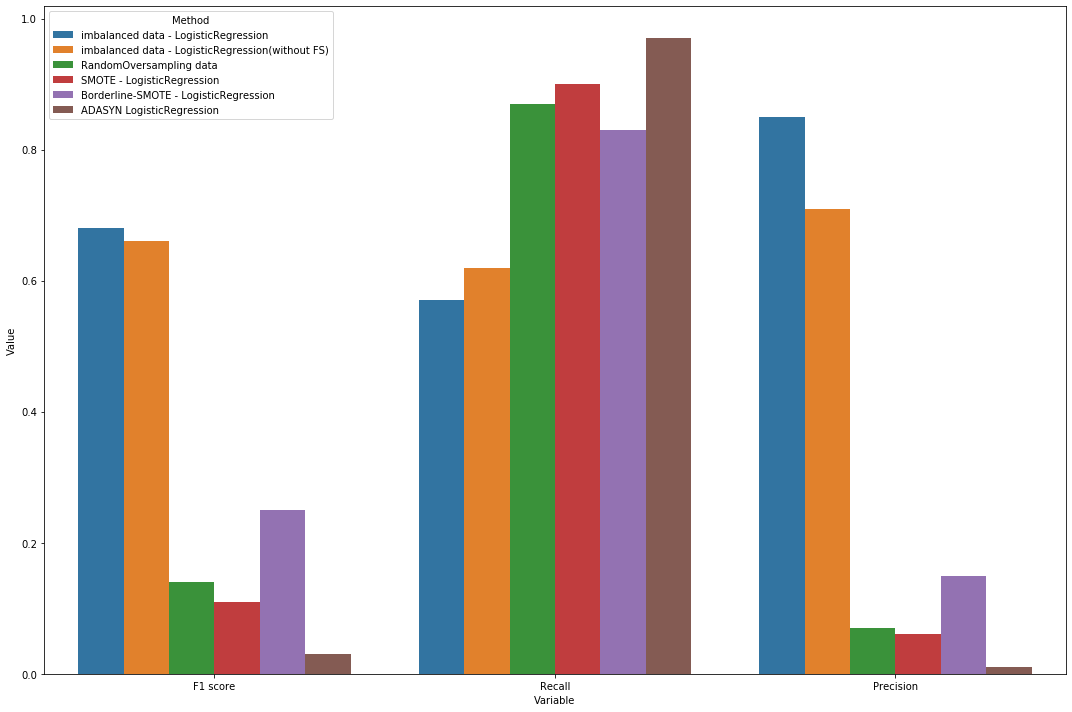

In [106]:
df_analysis_tidy = df_analysis.melt(id_vars='Method').rename(columns=str.title)
plt.figure(figsize=(15,10))
sns.barplot(x='Variable', y='Value', hue='Method', data=df_analysis_tidy)
plt.tight_layout()

# Threshold

Since the model is predicting Fraud too many type II errors is not advisable. A False Negative ( ignoring the probability of Fraud when there actualy is one) is more dangerous than a False Positive in this case. Hence inorder to increase the sensitivity, threshold can be lowered.
Sensitivity is the recall rate.

In [107]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)

In [108]:
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [109]:
clf = build_model(X_train, y_train)

The smaller the threshold, the larger the recall value, and the more the model can find out the number of stolen credit cards, but the price in exchange is that the number of misjudgments is also larger. As the threshold value increases, the recall value gradually decreases, the precision value gradually increases, and the number of misjudgments also decreases. By adjusting the model threshold, control the model's anti-credit card fraud strength. If you want to find out more stolen credit cards, set a smaller threshold, otherwise, set a larger threshold.

In [116]:
from sklearn.preprocessing import binarize

sensitivity_result = []
specifity_result = []
for i in range(0,11):
    cm2=0
    y_pred_prob_yes=clf.predict_proba(X_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    sensitivity_result.append(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])))
    specifity_result.append(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])))
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.0 threshold the Confusion Matrix is  
 [[    0 85308]
 [    0   135]] 
 with 135 correct predictions and 0 Type II errors( False Negatives) 

 Sensitivity:  1.0 Specificity:  0.0 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.1 threshold the Confusion Matrix is  
 [[85277    31]
 [   33   102]] 
 with 85379 correct predictions and 33 Type II errors( False Negatives) 

 Sensitivity:  0.7555555555555555 Specificity:  0.9996366108688517 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.2 threshold the Confusion Matrix is  
 [[85283    25]
 [   46    89]] 
 with 85372 correct predictions and 46 Type II errors( False Negatives) 

 Sensitivity:  0.6592592592592592 Specificity:  0.9997069442490739 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.3 threshold the Confusion Matrix is  
 [[85284    24]
 [   51    84]] 
 with 85368 correct predictions and 51 Type II errors( False Negatives) 

 Sensitivity:  0.6222222222222222 Specificity:  0.999718666479111 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.4 threshold the Confusion Matrix is  
 [[85290    18]
 [   56    79]] 
 with 85369 correct predictions and 56 Type II errors( False Negatives) 

 Sensitivity:  0.5851851851851851 Specificity:  0.9997889998593332 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.5 threshold the Confusion Matrix is  
 [[85294    14]
 [   58    77]] 
 with 85371 correct predictions and 58 Type II errors( False Negatives) 

 Sensitivity:  0.5703703703703704 Specificity:  0.9998358887794814 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.6 threshold the Confusion Matrix is  
 [[85295    13]
 [   60    75]] 
 with 85370 correct predictions and 60 Type II errors( False Negatives) 

 Sensitivity:  0.5555555555555556 Specificity:  0.9998476110095185 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.7 threshold the Confusion Matrix is  
 [[85296    12]
 [   62    73]] 
 with 85369 correct predictions and 62 Type II errors( False Negatives) 

 Sensitivity:  0.5407407407407407 Specificity:  0.9998593332395554 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.9 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.8 threshold the Confusion Matrix is  
 [[85296    12]
 [   64    71]] 
 with 85367 correct predictions and 64 Type II errors( False Negatives) 

 Sensitivity:  0.5259259259259259 Specificity:  0.9998593332395554 



With 0.9 threshold the Confusion Matrix is  
 [[85297    11]
 [   74    61]] 
 with 85358 correct predictions and 74 Type II errors( False Negatives) 

 Sensitivity:  0.45185185185185184 Specificity:  0.9998710554695925 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=1.0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 1.0 threshold the Confusion Matrix is  
 [[85308     0]
 [  135     0]] 
 with 85308 correct predictions and 135 Type II errors( False Negatives) 

 Sensitivity:  0.0 Specificity:  1.0 





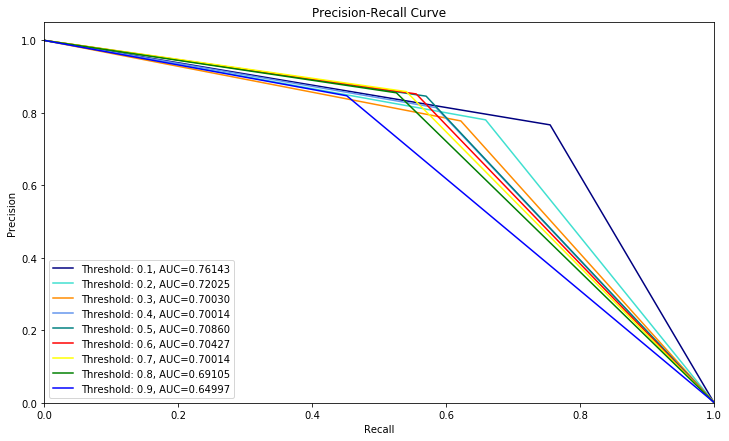

In [129]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(12,7))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_prob_yes[:,1] > i 

    precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions_prob)
    area = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s, AUC=%0.5f' %(i , area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

# ROC Curve

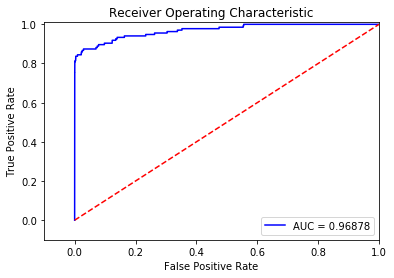

In [121]:
from sklearn.metrics import roc_curve

# defalut threshold 0.5
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob_yes[:,1])
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.5f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()